## Packages

In [ ]:
!pip install tf_keras_vis
!pip install keras_tuner -q
!pip install tensorflow
!pip install tensorflow-addons
!pip install -q transformers datasets evaluate accelerate -U

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix
from matplotlib import cm
import matplotlib.pyplot as plt
from datasets import DatasetDict, Dataset,load_metric
import evaluate
import torch
import PIL
from transformers import ViTFeatureExtractor, ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, pipeline, DefaultDataCollator
from transformers import ViTModel, ViTConfig
import torch.nn as nn
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn import metrics as pred_metrics
import random
import errno
import os

#Pretrained model checkpoint
model_checkpoint = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(model_checkpoint)
TYPE="_Balanced"
#TYPE=""

In [ ]:
torch.cuda.is_available()

True

**Functions**

In [ ]:
# Metrics to evaluate the predictions of our ViT model
def get_metrics(ytrue, ypred):
    # AUC
    auc = pred_metrics.roc_auc_score(ytrue, ypred)

    # Confusion matrix
    conf_matrix = pred_metrics.confusion_matrix(ytrue, ypred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Precision
    pre = pred_metrics.precision_score(ytrue, ypred)

    # Sensitivity / Recall
    rec = pred_metrics.recall_score(ytrue, ypred)

    # Accuracy
    acc = pred_metrics.accuracy_score(ytrue, ypred)

    # Specificity
    esp = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # False negative rate
    tfn = fn / (fn + tp) if (fn + tp) > 0 else 0.0

    # Positive predictive value
    vpt = tp / (fp + tp) if (fp + tp) > 0 else 0.0

    # Negative predictive value
    vpn = tn / (tn + fn) if (tn + fn) > 0 else 0.0

    # F1-Score
    f1 = pred_metrics.f1_score(ytrue, ypred)

    print('*' * 10, 'MÉTRICAS', '*' * 10)
    print('AUC: ', round(auc, 3))
    print('True Positives: ', tp)
    print('True Negatives: ', tn)
    print('False Positives: ', fp)
    print('False Negatives: ', fn)
    print('Precisión: ', round(pre, 3))
    print('Recall / Sensibilidad: ', round(rec, 3))
    print('Accuracy / Exactitud: ', round(acc, 3))
    print('Especificidad: ', round(esp, 3))
    print('Tasa falsos negativos: ', round(tfn, 3))
    print('Valor predictivo positivo: ', round(vpt, 3))
    print('Valor predictivo negativo: ', round(vpn, 3))
    print('F1-Score: ', round(f1, 3))
    print('*' * 30)
    return

In [ ]:
# Function to get the predictions of our dataset with metrics and confusion matrix
def prediccion_final(images,true_labels):
    predicted=[]

    for ruta in tqdm(images):
        preprocessed_test_image = feature_extractor([PIL.Image.open(ruta).convert("RGB")], return_tensors='pt')['pixel_values']
        with torch.no_grad():
            preds = model(preprocessed_test_image, output_attentions=True)
            predicted.append(preds)

    my_preds=[pred.logits.argmax().cpu().numpy().tolist() for pred in predicted]

    print("Métricas: ")
    matc=confusion_matrix(true_labels,
                          my_preds)
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(3,3))
    # Show confusion matrix with custom tags
    ax.imshow(matc, interpolation='nearest',cmap=cm.Blues)

    # Configure labels on axes
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels,rotation=90)

    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Etiquetas Verdaderas')
    # Add labels to each cell
    thresh = matc.max() / 2.0
    for i in range(matc.shape[0]):
        for j in range(matc.shape[1]):
            ax.text(j, i, format(matc[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if matc[i, j] > thresh else "black")
    plt.tight_layout()

    from sklearn import metrics as pred_metrics
    print(pred_metrics.classification_report(true_labels, my_preds, digits = 3))

    get_metrics(true_labels, my_preds)

    return

In [ ]:
# This functions allows us to know which case is mistaken labeled

def get_failed(images,true_labels):
    predicted=[]

    for ruta in tqdm(images):
        preprocessed_test_image = feature_extractor([PIL.Image.open(ruta).convert("RGB")], return_tensors='pt')['pixel_values']
        with torch.no_grad():
            preds = model(preprocessed_test_image, output_attentions=True)
            predicted.append(preds)

    my_preds=[pred.logits.argmax().cpu().numpy().tolist() for pred in predicted]

    print("Métricas: ")
    matc=confusion_matrix(true_labels,
                          my_preds)
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(3,3))
    # Show confusion matrix with custom tags
    ax.imshow(matc, interpolation='nearest',cmap=cm.Blues)

    # Configure labels on axes
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels,rotation=90)

    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Etiquetas Verdaderas')
    # Add labels to each cell
    thresh = matc.max() / 2.0
    for i in range(matc.shape[0]):
        for j in range(matc.shape[1]):
            ax.text(j, i, format(matc[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if matc[i, j] > thresh else "black")
    plt.tight_layout()

    for i,ruta in enumerate(images):
        if (true_labels[i] != my_preds[i]):
            print(ruta.split('/')[-1].split('.')[0])

    return

In [ ]:
# This function allows us to save the attention maps of our model for each case

def save_attention(output,image,dir):
    attentions = output.attentions[-1] # we are only interested in the attention maps of the last layer
    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    threshold = 0.6
    w_featmap = image.shape[-2] // model.config.patch_size
    h_featmap = image.shape[-1] // model.config.patch_size

    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - threshold)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu()
    attentions = attentions.detach().numpy()

    # show attentions heatmaps
    for j in range(nh):
        plt.imsave(fname=dir+"_attn-head_"+str(j)+".jpg", arr=attentions[j],format='jpg')
    return

In [ ]:
from tqdm.notebook import trange

# Automatically generate and save all our attention maps
def get_attentions_maps(my_data,prefijo):
    sets = ['test','valid','train']
    for s in sets:
        data = my_data[s]
        try:
            os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s)
            os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Cáncer')
            os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Control')
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

        for i in trange(len(data),desc="Procesando conjunto "+prefijo+s):
            image = data['image'][i]
            name = data['image'][i].split('/')[-1].split('.')[0]

            if 'C' in name:
                dir = './data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Cáncer/'+name
            else:
                dir = './data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Control/'+name

            input = feature_extractor([PIL.Image.open(image).convert("RGB")], return_tensors='pt')['pixel_values']
            with torch.no_grad():
                pred = model(input, output_attentions=True,interpolate_pos_encoding=True)
                save_attention(pred,input,dir)
        return

In [ ]:
# This functions gives us for each case the probabilities of being form one class or other
def get_probabilities(images,labels,conjunto):
    for i,ruta in enumerate(images):
        preprocessed_test_image = feature_extractor([PIL.Image.open(ruta).convert("RGB")],
                                                    return_tensors='pt')['pixel_values']
        name_img = ruta.split('/')[-1].split('.')[0]
        with torch.no_grad():
            preds = model(preprocessed_test_image)
            logits = preds.logits

            # Apply softmax for odds
            probabilities = torch.nn.functional.softmax(logits, dim=1)

            clas_pred=logits.argmax().cpu().numpy().tolist()
            prob_class0,prob_class1 = probabilities[0].tolist()

            data.append([conjunto,name_img,labels[i],clas_pred,prob_class0,prob_class1])

# Gold Data

## Load data

In [ ]:
#Original
new_ruta_train='./data'+TYPE+'/Gold_Standard/train'
new_ruta_test='./data'+TYPE+'/Gold_Standard/test'
new_ruta_valid='./data'+TYPE+'/Gold_Standard/valid'

#Segmentation
new_ruta_strain='./data'+TYPE+'/Gold_Standard/strain'
new_ruta_stest='./data'+TYPE+'/Gold_Standard/stest'
new_ruta_svalid='./data'+TYPE+'/Gold_Standard/svalid'

#Detection
new_ruta_dtrain='./data'+TYPE+'/Gold_Standard/dtrain'
new_ruta_dtest='./data'+TYPE+'/Gold_Standard/dtest'
new_ruta_dvalid='./data'+TYPE+'/Gold_Standard/dvalid'

In [ ]:
# ORIGINAL
random.seed(123)
# Transform to convert images to tensors
transform = ToTensor()

# Upload your data using ImageFolder
train_dataset = ImageFolder(new_ruta_train, transform=transform)
test_dataset = ImageFolder(new_ruta_test, transform=transform)
valid_dataset = ImageFolder(new_ruta_valid, transform=transform)

# Get images and tags as lists
train_samples = train_dataset.samples
test_samples = test_dataset.samples
valid_samples = valid_dataset.samples

# Mixing index randomly
random1_permutation = np.random.permutation(len(train_samples))
train_samples = [train_samples[i] for i in random1_permutation]

random2_permutation = np.random.permutation(len(test_samples))
test_samples = [test_samples[i] for i in random2_permutation]

random3_permutation = np.random.permutation(len(valid_samples))
valid_samples = [valid_samples[i] for i in random3_permutation]

# Create a DatasetDict and add the mixed data sets
data_dict = DatasetDict()

train_data = Dataset.from_dict({
    'image': [sample[0] for sample in train_samples],
    'labels': [sample[1] for sample in train_samples]
})
data_dict['train'] = train_data

valid_data = Dataset.from_dict({
    'image': [sample[0] for sample in valid_samples],
    'labels': [sample[1] for sample in valid_samples]
})
data_dict['valid'] = valid_data

test_data = Dataset.from_dict({
    'image': [sample[0] for sample in test_samples],
    'labels': [sample[1] for sample in test_samples]
})
data_dict['test'] = test_data

print(data_dict)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1605
    })
    valid: Dataset({
        features: ['image', 'labels'],
        num_rows: 810
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 107
    })
})


In [ ]:
# SEGMENTATION
# Upload your data using ImageFolder
strain_dataset = ImageFolder(new_ruta_strain, transform=transform)
stest_dataset = ImageFolder(new_ruta_stest, transform=transform)
svalid_dataset = ImageFolder(new_ruta_svalid, transform=transform)

# Get images and tags as lists
strain_samples = strain_dataset.samples
stest_samples = stest_dataset.samples
svalid_samples = svalid_dataset.samples

# Mixing index randomly
strain_samples = [strain_samples[i] for i in random1_permutation]
stest_samples = [stest_samples[i] for i in random2_permutation]
svalid_samples = [svalid_samples[i] for i in random3_permutation]

# Create a DatasetDict and add the mixed data sets
Sdata_dict = DatasetDict()

strain_data = Dataset.from_dict({
    'image': [sample[0] for sample in strain_samples],
    'labels': [sample[1] for sample in strain_samples]
})
Sdata_dict['train'] = strain_data

svalid_data = Dataset.from_dict({
    'image': [sample[0] for sample in svalid_samples],
    'labels': [sample[1] for sample in svalid_samples]
})
Sdata_dict['valid'] = svalid_data

stest_data = Dataset.from_dict({
    'image': [sample[0] for sample in stest_samples],
    'labels': [sample[1] for sample in stest_samples]
})
Sdata_dict['test'] = stest_data

print(Sdata_dict)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1605
    })
    valid: Dataset({
        features: ['image', 'labels'],
        num_rows: 810
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 107
    })
})


In [ ]:
# DETECTION
# Upload your data using ImageFolder
dtrain_dataset = ImageFolder(new_ruta_dtrain, transform=transform)
dtest_dataset = ImageFolder(new_ruta_dtest, transform=transform)
dvalid_dataset = ImageFolder(new_ruta_dvalid, transform=transform)

# Get images and tags as lists
dtrain_samples = dtrain_dataset.samples
dtest_samples = dtest_dataset.samples
dvalid_samples = dvalid_dataset.samples

# Mixing index randomly
dtrain_samples = [dtrain_samples[i] for i in random1_permutation]
dtest_samples = [dtest_samples[i] for i in random2_permutation]
dvalid_samples = [dvalid_samples[i] for i in random3_permutation]

# Create a DatasetDict and add the mixed data sets
Ddata_dict = DatasetDict()

dtrain_data = Dataset.from_dict({
    'image': [sample[0] for sample in dtrain_samples],
    'labels': [sample[1] for sample in dtrain_samples]
})
Ddata_dict['train'] = dtrain_data

dvalid_data = Dataset.from_dict({
    'image': [sample[0] for sample in dvalid_samples],
    'labels': [sample[1] for sample in dvalid_samples]
})
Ddata_dict['valid'] = dvalid_data

dtest_data = Dataset.from_dict({
    'image': [sample[0] for sample in dtest_samples],
    'labels': [sample[1] for sample in dtest_samples]
})
Ddata_dict['test'] = dtest_data

print(Ddata_dict)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1605
    })
    valid: Dataset({
        features: ['image', 'labels'],
        num_rows: 810
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 107
    })
})


In [ ]:
# Transform images
def transform(example_batch):
    inputs = feature_extractor([PIL.Image.open(image_path).convert("RGB") for image_path in example_batch['image']], return_tensors='pt')
    # Don’t forget to include the labels
    inputs['labels'] = example_batch['labels']
    return inputs

In [ ]:
#ORIGINAL
train_dataset = data_dict['train'].with_transform(transform)
test_dataset = data_dict['test'].with_transform(transform)
val_dataset = data_dict['valid'].with_transform(transform)

#SEGMENTATION
Strain_dataset = Sdata_dict['train'].with_transform(transform)
Stest_dataset = Sdata_dict['test'].with_transform(transform)
Sval_dataset = Sdata_dict['valid'].with_transform(transform)

#DETECTION
Dtrain_dataset = Ddata_dict['train'].with_transform(transform)
Dtest_dataset = Ddata_dict['test'].with_transform(transform)
Dval_dataset = Ddata_dict['valid'].with_transform(transform)

In [ ]:
print(data_dict['train'][0])
print(Sdata_dict['train'][0])
print(Ddata_dict['train'][0])

{'image': './data_Balanced/Gold_Standard/train/Control/00036_aug05.jpg', 'labels': 0}
{'image': './data_Balanced/Gold_Standard/strain/Control/00036_aug05(1).jpg', 'labels': 0}
{'image': './data_Balanced/Gold_Standard/dtrain/Control/00036_aug05.jpg', 'labels': 0}


In [ ]:
labels = ['Control','Cancer']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

label2id

{'Control': '0', 'Cancer': '1'}

## Model

In [ ]:
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
def collate_fn(batch):
    return {'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
            'labels': torch.tensor([x['labels'] for x in batch])}

In [ ]:
metric = evaluate.combine(["f1","accuracy"])
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
model = ViTForImageClassification.from_pretrained(model_checkpoint,
                                                  num_labels=len(labels),
                                                  id2label=id2label,
                                                  label2id=label2id)

Smodel = ViTForImageClassification.from_pretrained(model_checkpoint,
                                                  num_labels=len(labels),
                                                  id2label=id2label,
                                                  label2id=label2id)

Dmodel = ViTForImageClassification.from_pretrained(model_checkpoint,
                                                  num_labels=len(labels),
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(output_dir="./ViTresults/original"+TYPE,
                                  remove_unused_columns=False,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  gradient_accumulation_steps=4,
                                  num_train_epochs=10,
                                  warmup_ratio=0.1,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  push_to_hub=False)

Straining_args = TrainingArguments(output_dir="./ViTresults/segmentation"+TYPE,
                                  remove_unused_columns=False,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  gradient_accumulation_steps=4,
                                  num_train_epochs=10,
                                  warmup_ratio=0.1,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  push_to_hub=False)

Dtraining_args = TrainingArguments(output_dir="./ViTresults/detection"+TYPE,
                                  remove_unused_columns=False,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  gradient_accumulation_steps=4,
                                  num_train_epochs=10,
                                  warmup_ratio=0.1,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  push_to_hub=False)

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=feature_extractor)

Strainer = Trainer(model=Smodel,
                  args=Straining_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=Strain_dataset,
                  eval_dataset=Sval_dataset,
                  tokenizer=feature_extractor)

Dtrainer = Trainer(model=Dmodel,
                  args=Dtraining_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=Dtrain_dataset,
                  eval_dataset=Dval_dataset,
                  tokenizer=feature_extractor)

### Model evaluation of data sets before finetuning

In [ ]:
#TRAIN - GOLD Origial  - Sin entrenar
trainer.evaluate(train_dataset)

{'eval_loss': 0.6846144795417786,
 'eval_f1': 0.6842672413793104,
 'eval_accuracy': 0.6348909657320873,
 'eval_runtime': 1918.9284,
 'eval_samples_per_second': 0.836,
 'eval_steps_per_second': 0.418}

In [ ]:
#TRAIN - GOLD Segmentación - Sin entrenar
Strainer.evaluate(Strain_dataset)

{'eval_loss': 0.6914041042327881,
 'eval_f1': 0.6224390243902439,
 'eval_accuracy': 0.5177570093457944,
 'eval_runtime': 1156.9709,
 'eval_samples_per_second': 1.387,
 'eval_steps_per_second': 0.694}

In [ ]:
#TRAIN - GOLD Detección - Sin entrenar
Dtrainer.evaluate(Dtrain_dataset)

{'eval_loss': 0.7174965739250183,
 'eval_f1': 0.08981001727115717,
 'eval_accuracy': 0.3433021806853583,
 'eval_runtime': 421.1745,
 'eval_samples_per_second': 3.811,
 'eval_steps_per_second': 1.907}

In [ ]:
#VALID - GOLD Original - Sin entrenar
trainer.evaluate(val_dataset)

{'eval_loss': 0.6850542426109314,
 'eval_f1': 0.64859228362878,
 'eval_accuracy': 0.5839506172839506,
 'eval_runtime': 1004.3076,
 'eval_samples_per_second': 0.807,
 'eval_steps_per_second': 0.403}

In [ ]:
#VALID - GOLD Segmentación - Sin entrenar
Strainer.evaluate(Sval_dataset)

{'eval_loss': 0.6913259029388428,
 'eval_f1': 0.6221804511278196,
 'eval_accuracy': 0.5037037037037037,
 'eval_runtime': 219.1924,
 'eval_samples_per_second': 3.695,
 'eval_steps_per_second': 1.848}

In [ ]:
#VALID - GOLD Detección - Sin entrenar
Dtrainer.evaluate(Dval_dataset)

{'eval_loss': 0.722346842288971,
 'eval_f1': 0.03735144312393888,
 'eval_accuracy': 0.3,
 'eval_runtime': 211.2445,
 'eval_samples_per_second': 3.834,
 'eval_steps_per_second': 1.917}

In [ ]:
#TEST - GOLD Original - Sin entrenar
metrics = trainer.evaluate(test_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  eval_accuracy           =     0.6075
  eval_f1                 =     0.5227
  eval_loss               =     0.6821
  eval_runtime            = 0:00:05.54
  eval_samples_per_second =     19.287
  eval_steps_per_second   =      9.734


In [ ]:
#TEST - GOLD Segmentación - Sin entrenar
Smetrics = Strainer.evaluate(Stest_dataset)
Strainer.log_metrics("eval", Smetrics)
Strainer.save_metrics("eval", Smetrics)

***** eval metrics *****
  eval_accuracy           =     0.4953
  eval_f1                 =     0.5091
  eval_loss               =     0.6978
  eval_runtime            = 0:00:02.99
  eval_samples_per_second =     35.677
  eval_steps_per_second   =     18.005


In [ ]:
#TEST - GOLD Detección - Sin entrenar
Dmetrics = Dtrainer.evaluate(Dtest_dataset)
Dtrainer.log_metrics("eval", Dmetrics)
Dtrainer.save_metrics("eval", Dmetrics)

***** eval metrics *****
  eval_accuracy           =     0.6168
  eval_f1                 =     0.0465
  eval_loss               =     0.6749
  eval_runtime            = 0:00:02.18
  eval_samples_per_second =      49.07
  eval_steps_per_second   =     24.764


## Training Model & Predictions

### GOLD Orig

In [ ]:
#ORIGINAL
train_results = trainer.train()
trainer.save_model("./ViTresults/original"+TYPE)
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()
torch.save(model.state_dict(),"./ViTresults/ViT_Orig.pth")

Epoch,Training Loss,Validation Loss,F1,Accuracy
0,No log,0.150017,0.959288,0.960494
1,No log,0.160112,0.953459,0.954321
2,0.033300,0.173147,0.956843,0.956790
4,0.002700,0.193325,0.958128,0.958025
5,0.002700,0.200089,0.956843,0.956790
6,0.002700,0.207261,0.959410,0.959259
8,0.001600,0.214716,0.958231,0.958025
9,0.001300,0.216949,0.957055,0.956790


***** train metrics *****
  epoch                    =         9.96
  total_flos               = 1202569364GF
  train_loss               =       0.0097
  train_runtime            =   0:14:30.04
  train_samples_per_second =       18.447
  train_steps_per_second   =        2.299


In [ ]:
metrics = trainer.evaluate(test_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       9.96
  eval_accuracy           =     0.8972
  eval_f1                 =     0.8706
  eval_loss               =     0.3889
  eval_runtime            = 0:00:02.16
  eval_samples_per_second =     49.453
  eval_steps_per_second   =     24.957


In [ ]:
outputs = trainer.predict(test_dataset)
y_pred = outputs.predictions.argmax(1)
true_labels = data_dict['test']['labels']
print(pred_metrics.classification_report(true_labels, y_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.952     0.881     0.915        67
           1      0.822     0.925     0.871        40

    accuracy                          0.897       107
   macro avg      0.887     0.903     0.893       107
weighted avg      0.903     0.897     0.898       107



### GOLD Segmentation

In [ ]:
#SEGMENTATION
Strain_results = Strainer.train()
Strainer.save_model("./ViTresults/segmentation"+TYPE)
Strainer.log_metrics("train", Strain_results.metrics)
Strainer.save_metrics("train", Strain_results.metrics)
Strainer.save_state()
torch.save(Smodel.state_dict(),"./ViTresults/SViT.pth")

Epoch,Training Loss,Validation Loss,F1,Accuracy
0,No log,0.013545,0.998767,0.998765
1,No log,0.005191,1.000000,1.000000
2,0.084300,0.020409,0.996310,0.996296
4,0.002100,0.026766,0.993865,0.993827
5,0.002100,0.031986,0.992647,0.992593
6,0.002100,0.037568,0.992647,0.992593
8,0.001200,0.041691,0.992647,0.992593
9,0.001000,0.042085,0.992647,0.992593


***** train metrics *****
  epoch                    =         9.96
  total_flos               = 1154071098GF
  train_loss               =       0.0222
  train_runtime            =   0:13:50.86
  train_samples_per_second =       19.317
  train_steps_per_second   =        2.407


In [ ]:
Smetrics = Strainer.evaluate(Stest_dataset)
Strainer.log_metrics("eval", Smetrics)
Strainer.save_metrics("eval", Smetrics)

***** eval metrics *****
  epoch                   =       9.96
  eval_accuracy           =     0.9533
  eval_f1                 =     0.9383
  eval_loss               =     0.2085
  eval_runtime            = 0:00:02.16
  eval_samples_per_second =     49.446
  eval_steps_per_second   =     24.954


In [ ]:
outputsS = Strainer.predict(Stest_dataset)
y_predS = outputsS.predictions.argmax(1)
print(y_predS)
Strue_labels = Sdata_dict['test']['labels']
print(pred_metrics.classification_report(Strue_labels, y_predS, digits = 3))

[1 0 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1
 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1]
              precision    recall  f1-score   support

           0      0.970     0.955     0.962        67
           1      0.927     0.950     0.938        40

    accuracy                          0.953       107
   macro avg      0.948     0.953     0.950       107
weighted avg      0.954     0.953     0.953       107



### GOLD Detect

In [ ]:
#DETECTION
Dtrain_results = Dtrainer.train()
Dtrainer.save_model("./ViTresults/detection"+TYPE)
Dtrainer.log_metrics("train", Dtrain_results.metrics)
Dtrainer.save_metrics("train", Dtrain_results.metrics)
Dtrainer.save_state()
torch.save(Dmodel.state_dict(),"./ViTresults/DViT.pth")

Epoch,Training Loss,Validation Loss,F1,Accuracy
0,No log,0.207062,0.945776,0.946914
1,No log,0.578519,0.839542,0.861728
2,0.114300,0.200344,0.958231,0.958025
4,0.006400,0.304924,0.940618,0.938272
5,0.006400,0.337585,0.937278,0.934568
6,0.006400,0.358305,0.935065,0.932099
8,0.001600,0.380111,0.934118,0.930864
9,0.001200,0.383267,0.934118,0.930864


***** train metrics *****
  epoch                    =         9.96
  total_flos               = 1154648458GF
  train_loss               =       0.0309
  train_runtime            =   0:13:47.80
  train_samples_per_second =       19.389
  train_steps_per_second   =        2.416


In [ ]:
Dmetrics = Dtrainer.evaluate(Dtest_dataset)
Dtrainer.log_metrics("eval", Dmetrics)
Dtrainer.save_metrics("eval", Dmetrics)

***** eval metrics *****
  epoch                   =       9.96
  eval_accuracy           =     0.8972
  eval_f1                 =     0.8764
  eval_loss               =     0.4768
  eval_runtime            = 0:00:02.40
  eval_samples_per_second =     44.488
  eval_steps_per_second   =     22.452


In [ ]:
outputsD = Dtrainer.predict(Dtest_dataset)
y_predD = outputsD.predictions.argmax(1)
print(y_predD)
Dtrue_labels = Ddata_dict['test']['labels']
print(pred_metrics.classification_report(Dtrue_labels, y_predD, digits = 3))

[1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1
 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0]
              precision    recall  f1-score   support

           0      0.983     0.851     0.912        67
           1      0.796     0.975     0.876        40

    accuracy                          0.897       107
   macro avg      0.889     0.913     0.894       107
weighted avg      0.913     0.897     0.899       107



# SAM and DETR predictions

## Load data

In [ ]:
#DETR (Original-DETR)
DETR_train='./data'+TYPE+'/DETR/train'
DETR_test='./data'+TYPE+'/DETR/test'
DETR_valid='./data'+TYPE+'/DETR/valid'

In [ ]:
#SAM  (DETR-SAM)
SAM_train='./data'+TYPE+'/SAM+DETR/train'
SAM_test='./data'+TYPE+'/SAM+DETR/test'
SAM_valid='./data'+TYPE+'/SAM+DETR/valid'

In [ ]:
#SAM 2 (SAM with Gold BBOX)
SAM2_train='./data'+TYPE+'/SAM/train'
SAM2_test= './data'+TYPE+'/SAM/test'
SAM2_valid='./data'+TYPE+'/SAM/valid'

In [ ]:
# DETR
random.seed(123)
# Transform to convert images to tensors
transform = ToTensor()

# Upload your data using ImageFolder
train_dataset = ImageFolder(DETR_train, transform=transform)
test_dataset = ImageFolder(DETR_test, transform=transform)
valid_dataset = ImageFolder(DETR_valid, transform=transform)

# Get images and tags as lists
train_samples = train_dataset.samples
test_samples = test_dataset.samples
valid_samples = valid_dataset.samples

# Mixing indices randomly
random_permutation1 = np.random.permutation(len(train_samples))
train_samples = [train_samples[i] for i in random_permutation1]

random_permutation2 = np.random.permutation(len(test_samples))
test_samples = [test_samples[i] for i in random_permutation2]

random_permutation3 = np.random.permutation(len(valid_samples))
valid_samples = [valid_samples[i] for i in random_permutation3]

# Create a DatasetDict and add the mixed data sets
detr_dict = DatasetDict()

train_data = Dataset.from_dict({
    'image': [sample[0] for sample in train_samples],
    'labels': [sample[1] for sample in train_samples]
})
detr_dict['train'] = train_data

valid_data = Dataset.from_dict({
    'image': [sample[0] for sample in valid_samples],
    'labels': [sample[1] for sample in valid_samples]
})
detr_dict['valid'] = valid_data

test_data = Dataset.from_dict({
    'image': [sample[0] for sample in test_samples],
    'labels': [sample[1] for sample in test_samples]
})
detr_dict['test'] = test_data

print(detr_dict)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1605
    })
    valid: Dataset({
        features: ['image', 'labels'],
        num_rows: 810
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 107
    })
})


In [ ]:
# SAM
random.seed(123)
# Transform to convert images to tensors
transform = ToTensor()

# Upload your data using ImageFolder
train_dataset = ImageFolder(SAM_train, transform=transform)
test_dataset = ImageFolder(SAM_test, transform=transform)
valid_dataset = ImageFolder(SAM_valid, transform=transform)

# Get images and tags as lists
train_samples = train_dataset.samples
test_samples = test_dataset.samples
valid_samples = valid_dataset.samples

# Mixing indices randomly
random_permutation = np.random.permutation(len(train_samples))
train_samples = [train_samples[i] for i in random_permutation1]

random_permutation = np.random.permutation(len(test_samples))
test_samples = [test_samples[i] for i in random_permutation2]

random_permutation = np.random.permutation(len(valid_samples))
valid_samples = [valid_samples[i] for i in random_permutation3]

# Create a DatasetDict and add the mixed data sets
sam_dict = DatasetDict()

train_data = Dataset.from_dict({
    'image': [sample[0] for sample in train_samples],
    'labels': [sample[1] for sample in train_samples]
})
sam_dict['train'] = train_data

valid_data = Dataset.from_dict({
    'image': [sample[0] for sample in valid_samples],
    'labels': [sample[1] for sample in valid_samples]
})
sam_dict['valid'] = valid_data

test_data = Dataset.from_dict({
    'image': [sample[0] for sample in test_samples],
    'labels': [sample[1] for sample in test_samples]
})
sam_dict['test'] = test_data

print(sam_dict)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1605
    })
    valid: Dataset({
        features: ['image', 'labels'],
        num_rows: 810
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 107
    })
})


In [ ]:
# SAM 2 (SAM with Gold BBOX)
random.seed(123)
# Transform to convert images to tensors
transform = ToTensor()

# Upload your data using ImageFolder
train_dataset = ImageFolder(SAM2_train, transform=transform)
test_dataset = ImageFolder(SAM2_test, transform=transform)
valid_dataset = ImageFolder(SAM2_valid, transform=transform)

# Get images and tags as lists
train_samples = train_dataset.samples
test_samples = test_dataset.samples
valid_samples = valid_dataset.samples

# Mixing indices randomly
random_permutation = np.random.permutation(len(train_samples))
train_samples = [train_samples[i] for i in random_permutation1]

random_permutation = np.random.permutation(len(test_samples))
test_samples = [test_samples[i] for i in random_permutation2]

random_permutation = np.random.permutation(len(valid_samples))
valid_samples = [valid_samples[i] for i in random_permutation3]

# Create a DatasetDict and add the mixed data sets
sam_dict2 = DatasetDict()

train_data = Dataset.from_dict({
    'image': [sample[0] for sample in train_samples],
    'labels': [sample[1] for sample in train_samples]
})
sam_dict2['train'] = train_data

valid_data = Dataset.from_dict({
    'image': [sample[0] for sample in valid_samples],
    'labels': [sample[1] for sample in valid_samples]
})
sam_dict2['valid'] = valid_data

test_data = Dataset.from_dict({
    'image': [sample[0] for sample in test_samples],
    'labels': [sample[1] for sample in test_samples]
})
sam_dict2['test'] = test_data

print(sam_dict2)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1605
    })
    valid: Dataset({
        features: ['image', 'labels'],
        num_rows: 810
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 107
    })
})


In [ ]:
print(detr_dict['train'][0],'\n',DETR_train_dataset[0])

{'image': './data_Balanced/DETR/train/Control/00021_aug06.jpg', 'labels': 0} 
 {'pixel_values': tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ...,  0.0588,  0.0745,  0.0745],
         [-1.0000, -1.0000, -1.0000,  ...,  0.0667,  0.0667,  0.0745],
         [-1.0000, -1.0000, -1.0000,  ...,  0.0902,  0.0745,  0.0745]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.2627, -0.2471, -0.2471],
         [-1.0000, -1.0000, -1.0000,  ..., -0.2549, -0.2627, -0.2627],
         [-1.0000, -1.0000, -1.0000,  ..., -0.2314, -0.2627, -0.2627]],

        [[-1.0000, -

In [ ]:
labels = ['Control','Cancer']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

label2id

{'Control': '0', 'Cancer': '1'}

**Load the previous models and predict with this new data**

## Predictions & Metrics


### Other metrics and values from ORIGINAL TRAINED MODEL

In [ ]:
model = ViTForImageClassification.from_pretrained(model_checkpoint,
                                                  num_labels=len(labels),
                                                  id2label=id2label,
                                                  label2id=label2id)
model.load_state_dict(torch.load("./ViTresults/original_Balanced/ViT_Orig.pth"))
model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=feature_extractor)
#TRAIN - GOLD Origial  - Entrenado
trainer.evaluate(train_dataset)

{'eval_loss': 0.0014514174545183778,
 'eval_f1': 1.0,
 'eval_accuracy': 1.0,
 'eval_runtime': 28.7256,
 'eval_samples_per_second': 55.873,
 'eval_steps_per_second': 27.954}

In [ ]:
#TRAIN - GOLD Origial  - Trained
trainer.evaluate(val_dataset)

{'eval_loss': 0.2072608321905136,
 'eval_f1': 0.959409594095941,
 'eval_accuracy': 0.9592592592592593,
 'eval_runtime': 16.8028,
 'eval_samples_per_second': 48.206,
 'eval_steps_per_second': 24.103}

In [ ]:
#TRAIN - GOLD Original - Prediction
images = data_dict['train']['image']
true_labels = data_dict['train']['labels']
prediccion_final(images,true_labels)

In [ ]:
#VALID - GOLD Original - Prediction
images = data_dict['valid']['image']
true_labels = data_dict['valid']['labels']
prediccion_final(images,true_labels)



  0%|                                                                                 | 0/107 [00:00<?, ?it/s]

  1%|▋                                                                        | 1/107 [00:06<11:33,  6.54s/it]

  2%|█▎                                                                       | 2/107 [00:12<11:17,  6.46s/it]

  3%|██                                                                       | 3/107 [00:19<11:19,  6.54s/it]

  4%|██▋                                                                      | 4/107 [00:25<10:53,  6.34s/it]

  5%|███▍                                                                     | 5/107 [00:30<10:03,  5.92s/it]

  6%|████                                                                     | 6/107 [00:38<10:43,  6.38s/it]

  7%|████▊                                                                    | 7/107 [00:44<10:35,  6.35s/it]

  7%|█████▍                                                                   | 8/107 [00:50<10:32,  6

Métricas: 
              precision    recall  f1-score   support

           0      0.952     0.896     0.923        67
           1      0.841     0.925     0.881        40

    accuracy                          0.907       107
   macro avg      0.897     0.910     0.902       107
weighted avg      0.911     0.907     0.907       107

********** MÉTRICAS **********
AUC:  0.91
True Positives:  37
True Negatives:  60
False Positives:  7
False Negatives:  3
Precisión:  0.841
Recall / Sensibilidad:  0.925
Accuracy / Exactitud:  0.907
Especificidad:  0.896
Tasa falsos negativos:  0.075
Valor predictivo positivo:  0.841
Valor predictivo negativo:  0.952
F1-Score:  0.881
******************************


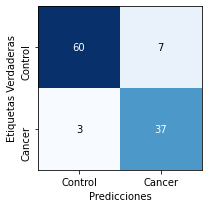

In [ ]:
#TEST - GOLD Original - Prediction
random.seed(123)
images = data_dict['test']['image']
true_labels = data_dict['test']['labels']
prediccion_final(images,true_labels)


100%|███████████████████████████████████████████████████████████████████████| 107/107 [06:59<00:00,  3.92s/it]

Métricas: 
00135
00101
00080C
00184
00008C
00072
00144
00120C
00115
00109


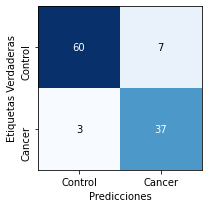

In [ ]:
random.seed(123)
get_failed(images,true_labels)

In [ ]:
random.seed(123)
output_file_path='probs_ViT_Original.csv'
sets = ['test','valid','train']
for s in sets:
    data=[]
    images = data_dict[s]['image']
    true_labels = data_dict[s]['labels']

    get_probabilities(images,true_labels,s)

    columns = ['conjunto','name_imagen','true_class','pred_class','prob_class0','prob_class1']
    df = pd.DataFrame(data,columns=columns)

    if os.path.exists(output_file_path):
        existing_df = pd.read_csv(output_file_path)
        final_df = pd.concat([existing_df, df], ignore_index=True)
    else:
        final_df = df

    # Save the updated DataFrame to the same CSV file
    final_df.to_csv(output_file_path, index=False)

### DETR

In [ ]:
model = ViTForImageClassification.from_pretrained(model_checkpoint,
                                                  num_labels=len(labels),
                                                  id2label=id2label,
                                                  label2id=label2id)
model.load_state_dict(torch.load("./ViTresults/detection_Balanced/DViT.pth"))
model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
Dtrainer = Trainer(model=model,
                  args=Dtraining_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=Dtrain_dataset,
                  eval_dataset=Dval_dataset,
                  tokenizer=feature_extractor)

In [ ]:
#TRAIN - GOLD Det  - Trained
Dtrainer.evaluate(Dtrain_dataset)

{'eval_loss': 0.003669728059321642,
 'eval_f1': 1.0,
 'eval_accuracy': 1.0,
 'eval_runtime': 27.497,
 'eval_samples_per_second': 58.37,
 'eval_steps_per_second': 29.203}

100%|███████████████████████████████████████████████████████████████████████| 107/107 [01:20<00:00,  1.33it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.983     0.851     0.912        67
           1      0.796     0.975     0.876        40

    accuracy                          0.897       107
   macro avg      0.889     0.913     0.894       107
weighted avg      0.913     0.897     0.899       107

********** MÉTRICAS **********
AUC:  0.913
True Positives:  39
True Negatives:  57
False Positives:  10
False Negatives:  1
Precisión:  0.796
Recall / Sensibilidad:  0.975
Accuracy / Exactitud:  0.897
Especificidad:  0.851
Tasa falsos negativos:  0.025
Valor predictivo positivo:  0.796
Valor predictivo negativo:  0.983
F1-Score:  0.876
******************************


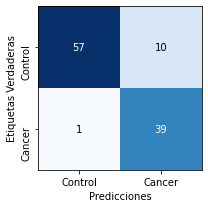

In [ ]:
#Test Prediction- GOLD BB
images = Ddata_dict['test']['image']
true_labels = Ddata_dict['test']['labels']
prediccion_final(images,true_labels)


100%|███████████████████████████████████████████████████████████████████████| 107/107 [06:41<00:00,  3.76s/it]


Métricas: 
              precision    recall  f1-score   support

           0      0.983     0.851     0.912        67
           1      0.796     0.975     0.876        40

    accuracy                          0.897       107
   macro avg      0.889     0.913     0.894       107
weighted avg      0.913     0.897     0.899       107

********** MÉTRICAS **********
AUC:  0.913
True Positives:  39
True Negatives:  57
False Positives:  10
False Negatives:  1
Precisión:  0.796
Recall / Sensibilidad:  0.975
Accuracy / Exactitud:  0.897
Especificidad:  0.851
Tasa falsos negativos:  0.025
Valor predictivo positivo:  0.796
Valor predictivo negativo:  0.983
F1-Score:  0.876
******************************



100%|███████████████████████████████████████████████████████████████████████| 107/107 [06:52<00:00,  3.85s/it]

Métricas: 
00135
00013
00102
00080C
00037
00072
00061
00144
00156
00065
00112


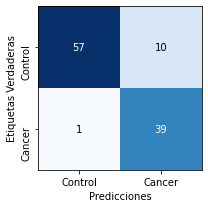

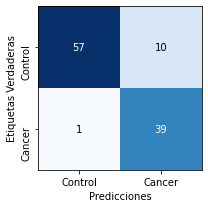

In [ ]:
images = Ddata_dict['test']['image']
true_labels = Ddata_dict['test']['labels']
prediccion_final(images,true_labels)
get_failed(images,true_labels)

In [ ]:
#VALID - GOLD Det  - Trained
Dtrainer.evaluate(Dval_dataset)

{'eval_loss': 0.2003437876701355,
 'eval_f1': 0.9582309582309582,
 'eval_accuracy': 0.9580246913580247,
 'eval_runtime': 15.7546,
 'eval_samples_per_second': 51.413,
 'eval_steps_per_second': 25.707}

In [ ]:
#Gold Detection prediction files
output_file_path='probs_ViT_Deteccion.csv'
sets = ['test','valid','train']
for s in sets:
    data=[]
    images = Ddata_dict[s]['image']
    true_labels = Ddata_dict[s]['labels']

    get_probabilities(images,true_labels,s)

    columns = ['conjunto','name_imagen','true_class','pred_class','prob_class0','prob_class1']
    df = pd.DataFrame(data,columns=columns)

    if os.path.exists(output_file_path):
        existing_df = pd.read_csv(output_file_path)
        final_df = pd.concat([existing_df, df], ignore_index=True)
    else:
        final_df = df

    final_df.to_csv(output_file_path, index=False)




  0%|                                                                                 | 0/107 [00:00<?, ?it/s]Exception ignored in: <function tqdm.__del__ at 0x7f77e1d51c60>
Traceback (most recent call last):
  File "/home/eva/.local/lib/python3.10/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/home/eva/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/home/eva/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 150, in display
    d = self.format_dict
  File "/home/eva/.local/lib/python3.10/site-packages/tqdm/std.py", line 1463, in format_dict
    'colour': self.colour}
  File "/home/eva/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 194, in colour
    return self.container.children[-2].style.bar_color
AttributeError: 'FloatProgress' object has no attribute 'style'



  1%|▋                                                                        | 1

Métricas: 
              precision    recall  f1-score   support

           0      0.912     0.776     0.839        67
           1      0.700     0.875     0.778        40

    accuracy                          0.813       107
   macro avg      0.806     0.826     0.808       107
weighted avg      0.833     0.813     0.816       107

********** MÉTRICAS **********
AUC:  0.826
True Positives:  35
True Negatives:  52
False Positives:  15
False Negatives:  5
Precisión:  0.7
Recall / Sensibilidad:  0.875
Accuracy / Exactitud:  0.813
Especificidad:  0.776
Tasa falsos negativos:  0.125
Valor predictivo positivo:  0.7
Valor predictivo negativo:  0.912
F1-Score:  0.778
******************************



100%|███████████████████████████████████████████████████████████████████████| 107/107 [06:46<00:00,  3.80s/it]

Métricas: 
00008C
00063C
00015C
00159
00027
00135
00047
00109
00004
00181
00065
00050
00101
00118C
00144
00112
00002
00072C
00143
00061


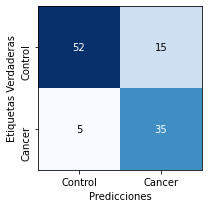

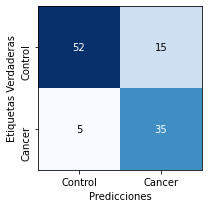

In [ ]:
#DETR BB prediction
images = detr_dict['test']['image']
true_labels = detr_dict['test']['labels']
prediccion_final(images,true_labels)
get_failed(images,true_labels)

100%|███████████████████████████████████████████████████████████████████████| 107/107 [01:32<00:00,  1.16it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.912     0.776     0.839        67
           1      0.700     0.875     0.778        40

    accuracy                          0.813       107
   macro avg      0.806     0.826     0.808       107
weighted avg      0.833     0.813     0.816       107

********** MÉTRICAS **********
AUC:  0.826
True Positives:  35
True Negatives:  52
False Positives:  15
False Negatives:  5
Precisión:  0.7
Recall / Sensibilidad:  0.875
Accuracy / Exactitud:  0.813
Especificidad:  0.776
Tasa falsos negativos:  0.125
Valor predictivo positivo:  0.7
Valor predictivo negativo:  0.912
F1-Score:  0.778
******************************


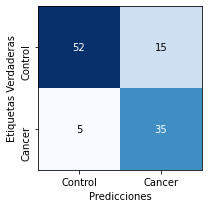

In [ ]:
#Test Prediction- DETR bbox
images = detr_dict['test']['image']
true_labels = detr_dict['test']['labels']
prediccion_final(images,true_labels)

In [ ]:
#get_attentions_maps(detr_dict,prefijo='DETR_')
prefijo='DETR_'
sets = ['test','valid','train']
for s in sets:
    data = detr_dict[s]
    try:
        os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s)
        os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Cáncer')
        os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Control')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

    for i in trange(len(data),desc="Procesando conjunto "+prefijo+s):
        image = data['image'][i]
        name = data['image'][i].split('/')[-1].split('.')[0]

        if 'C' in name:
            dir = './data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Cáncer/'+name
        else:
            dir = './data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Control/'+name

        input = feature_extractor([PIL.Image.open(image).convert("RGB")], return_tensors='pt')['pixel_values']
        with torch.no_grad():
            pred = model(input, output_attentions=True,interpolate_pos_encoding=True)
            save_attention(pred,input,dir)

Procesando conjunto DETR_test:   0%|          | 0/107 [00:00<?, ?it/s]

Procesando conjunto DETR_valid:   0%|          | 0/810 [00:00<?, ?it/s]

Procesando conjunto DETR_train:   0%|          | 0/1605 [00:00<?, ?it/s]

In [ ]:
#DETR  prediction files
output_file_path='probs_ViT_DETR.csv'
sets = ['test','valid','train']
for s in sets:
    data=[]
    images = detr_dict[s]['image']
    true_labels = detr_dict[s]['labels']

    get_probabilities(images,true_labels,s)

    columns = ['conjunto','name_imagen','true_class','pred_class','prob_class0','prob_class1']
    df = pd.DataFrame(data,columns=columns)

    if os.path.exists(output_file_path):
        existing_df = pd.read_csv(output_file_path)
        # Concatenar el DataFrame existente y el nuevo DataFrame
        final_df = pd.concat([existing_df, df], ignore_index=True)
    else:
        final_df = df

    # Guardar el DataFrame actualizado en el mismo archivo CSV
    final_df.to_csv(output_file_path, index=False)

#### About train & valid data

100%|█████████████████████████████████████████████████████████████████████| 1605/1605 [03:18<00:00,  8.07it/s]


Métricas: 
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       810
           1      1.000     1.000     1.000       795

    accuracy                          1.000      1605
   macro avg      1.000     1.000     1.000      1605
weighted avg      1.000     1.000     1.000      1605



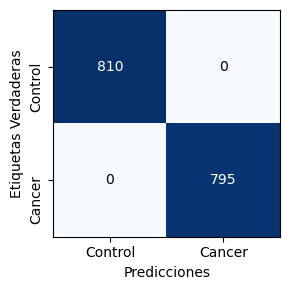

In [ ]:
#TRAIN - GOLD Det - Prediction
images = Ddata_dict['train']['image']
true_labels = Ddata_dict['train']['labels']
predicted=[]

for ruta in tqdm(images):
    preprocessed_test_image = feature_extractor([PIL.Image.open(ruta).convert("RGB")], return_tensors='pt')['pixel_values']
    with torch.no_grad():
        preds = model(preprocessed_test_image, output_attentions=True)
        predicted.append(preds)

my_preds=[pred.logits.argmax().cpu().numpy().tolist() for pred in predicted]

print("Métricas: ")
matc=confusion_matrix(true_labels,
                      my_preds)
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(3,3))
# Mostrar la matriz de confusión con etiquetas personalizadas
ax.imshow(matc, interpolation='nearest',cmap=cm.Blues)

# Configurar etiquetas en los ejes
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels,rotation=90)

ax.set_xlabel('Predicciones')
ax.set_ylabel('Etiquetas Verdaderas')
# Agregar etiquetas a cada celda
thresh = matc.max() / 2.0
for i in range(matc.shape[0]):
    for j in range(matc.shape[1]):
        ax.text(j, i, format(matc[i, j], 'd'),
                ha="center", va="center",
                color="white" if matc[i, j] > thresh else "black")
plt.tight_layout()

from sklearn import metrics as pred_metrics
print(pred_metrics.classification_report(true_labels, my_preds, digits = 3))

100%|███████████████████████████████████████████████████████████████████████| 810/810 [01:38<00:00,  8.21it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.963     0.953     0.958       405
           1      0.954     0.963     0.958       405

    accuracy                          0.958       810
   macro avg      0.958     0.958     0.958       810
weighted avg      0.958     0.958     0.958       810



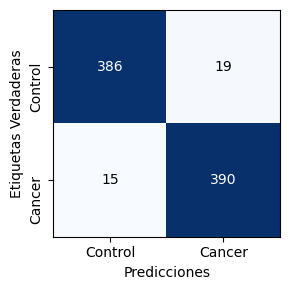

In [ ]:
#VALID - GOLD Det - Prediction
images = Ddata_dict['valid']['image']
true_labels = Ddata_dict['valid']['labels']
predicted=[]

for ruta in tqdm(images):
    preprocessed_test_image = feature_extractor([PIL.Image.open(ruta).convert("RGB")], return_tensors='pt')['pixel_values']
    with torch.no_grad():
        preds = model(preprocessed_test_image, output_attentions=True)
        predicted.append(preds)

my_preds=[pred.logits.argmax().cpu().numpy().tolist() for pred in predicted]

print("Métricas: ")
matc=confusion_matrix(true_labels,
                      my_preds)
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(3,3))
# Mostrar la matriz de confusión con etiquetas personalizadas
ax.imshow(matc, interpolation='nearest',cmap=cm.Blues)

# Configurar etiquetas en los ejes
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels,rotation=90)

ax.set_xlabel('Predicciones')
ax.set_ylabel('Etiquetas Verdaderas')
# Agregar etiquetas a cada celda
thresh = matc.max() / 2.0
for i in range(matc.shape[0]):
    for j in range(matc.shape[1]):
        ax.text(j, i, format(matc[i, j], 'd'),
                ha="center", va="center",
                color="white" if matc[i, j] > thresh else "black")
plt.tight_layout()

from sklearn import metrics as pred_metrics
print(pred_metrics.classification_report(true_labels, my_preds, digits = 3))

100%|█████████████████████████████████████████████████████████████████████| 1605/1605 [03:19<00:00,  8.03it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.998     0.642     0.781       810
           1      0.732     0.999     0.845       795

    accuracy                          0.819      1605
   macro avg      0.865     0.820     0.813      1605
weighted avg      0.867     0.819     0.813      1605



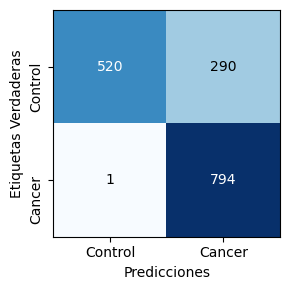

In [ ]:
#TRAIN - DETR - Prediction
images = detr_dict['train']['image']
true_labels = detr_dict['train']['labels']
predicted=[]

for ruta in tqdm(images):
    preprocessed_test_image = feature_extractor([PIL.Image.open(ruta).convert("RGB")], return_tensors='pt')['pixel_values']
    with torch.no_grad():
        preds = model(preprocessed_test_image, output_attentions=True)
        predicted.append(preds)

my_preds=[pred.logits.argmax().cpu().numpy().tolist() for pred in predicted]

print("Métricas: ")
matc=confusion_matrix(true_labels,
                      my_preds)
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(3,3))
# Mostrar la matriz de confusión con etiquetas personalizadas
ax.imshow(matc, interpolation='nearest',cmap=cm.Blues)

# Configurar etiquetas en los ejes
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels,rotation=90)

ax.set_xlabel('Predicciones')
ax.set_ylabel('Etiquetas Verdaderas')
# Agregar etiquetas a cada celda
thresh = matc.max() / 2.0
for i in range(matc.shape[0]):
    for j in range(matc.shape[1]):
        ax.text(j, i, format(matc[i, j], 'd'),
                ha="center", va="center",
                color="white" if matc[i, j] > thresh else "black")
plt.tight_layout()

from sklearn import metrics as pred_metrics
print(pred_metrics.classification_report(true_labels, my_preds, digits = 3))

100%|███████████████████████████████████████████████████████████████████████| 810/810 [01:47<00:00,  7.56it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.897     0.667     0.765       405
           1      0.735     0.923     0.818       405

    accuracy                          0.795       810
   macro avg      0.816     0.795     0.792       810
weighted avg      0.816     0.795     0.792       810



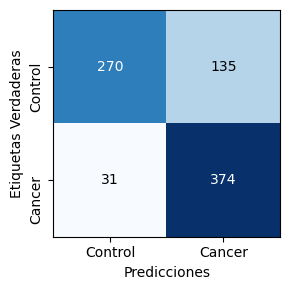

In [ ]:
#VALID - DETR - Prediction
images = detr_dict['valid']['image']
true_labels = detr_dict['valid']['labels']
predicted=[]

for ruta in tqdm(images):
    preprocessed_test_image = feature_extractor([PIL.Image.open(ruta).convert("RGB")], return_tensors='pt')['pixel_values']
    with torch.no_grad():
        preds = model(preprocessed_test_image, output_attentions=True)
        predicted.append(preds)

my_preds=[pred.logits.argmax().cpu().numpy().tolist() for pred in predicted]

print("Métricas: ")
matc=confusion_matrix(true_labels,
                      my_preds)
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(3,3))
# Mostrar la matriz de confusión con etiquetas personalizadas
ax.imshow(matc, interpolation='nearest',cmap=cm.Blues)

# Configurar etiquetas en los ejes
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels,rotation=90)

ax.set_xlabel('Predicciones')
ax.set_ylabel('Etiquetas Verdaderas')
# Agregar etiquetas a cada celda
thresh = matc.max() / 2.0
for i in range(matc.shape[0]):
    for j in range(matc.shape[1]):
        ax.text(j, i, format(matc[i, j], 'd'),
                ha="center", va="center",
                color="white" if matc[i, j] > thresh else "black")
plt.tight_layout()

from sklearn import metrics as pred_metrics
print(pred_metrics.classification_report(true_labels, my_preds, digits = 3))

### SAM

In [ ]:
model = ViTForImageClassification.from_pretrained(model_checkpoint,
                                                  num_labels=len(labels),
                                                  id2label=id2label,
                                                  label2id=label2id)
model.load_state_dict(torch.load("./ViTresults/segmentation_Balanced/SViT.pth"))
model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

100%|███████████████████████████████████████████████████████████████████████| 107/107 [04:02<00:00,  2.27s/it]

Métricas: 
              precision    recall  f1-score   support

           0      0.970     0.970     0.970        67
           1      0.950     0.950     0.950        40

    accuracy                          0.963       107
   macro avg      0.960     0.960     0.960       107
weighted avg      0.963     0.963     0.963       107

********** MÉTRICAS **********
AUC:  0.96
True Positives:  38
True Negatives:  65
False Positives:  2
False Negatives:  2
Precisión:  0.95
Recall / Sensibilidad:  0.95
Accuracy / Exactitud:  0.963
Especificidad:  0.97
Tasa falsos negativos:  0.05
Valor predictivo positivo:  0.95
Valor predictivo negativo:  0.97
F1-Score:  0.95
******************************


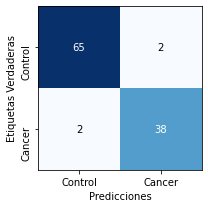

In [ ]:
#Gold Mask - Prediction
images = Sdata_dict['test']['image']
true_labels = Sdata_dict['test']['labels']
prediccion_final(images,true_labels)


100%|███████████████████████████████████████████████████████████████████████| 107/107 [08:34<00:00,  4.81s/it]


Métricas: 
              precision    recall  f1-score   support

           0      0.970     0.970     0.970        67
           1      0.950     0.950     0.950        40

    accuracy                          0.963       107
   macro avg      0.960     0.960     0.960       107
weighted avg      0.963     0.963     0.963       107

********** MÉTRICAS **********
AUC:  0.96
True Positives:  38
True Negatives:  65
False Positives:  2
False Negatives:  2
Precisión:  0.95
Recall / Sensibilidad:  0.95
Accuracy / Exactitud:  0.963
Especificidad:  0.97
Tasa falsos negativos:  0.05
Valor predictivo positivo:  0.95
Valor predictivo negativo:  0.97
F1-Score:  0.95
******************************



100%|███████████████████████████████████████████████████████████████████████| 107/107 [08:00<00:00,  4.49s/it]

Métricas: 
00114C(1)
00102(1)
00089C(1)
00061(1)


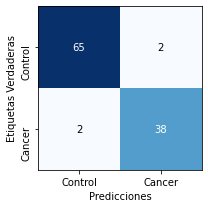

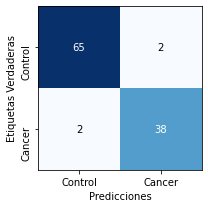

In [ ]:
images = Sdata_dict['test']['image']
true_labels = Sdata_dict['test']['labels']
prediccion_final(images,true_labels)
get_failed(images,true_labels)

In [ ]:
#Gold Segmentation predictions files
output_file_path='probs_ViT_Segmentacion.csv'
sets = ['test','valid','train']
for s in sets:
    data=[]
    images = Sdata_dict[s]['image']
    true_labels = Sdata_dict[s]['labels']

    get_probabilities(images,true_labels,s)

    columns = ['conjunto','name_imagen','true_class','pred_class','prob_class0','prob_class1']
    df = pd.DataFrame(data,columns=columns)

    if os.path.exists(output_file_path):
        existing_df = pd.read_csv(output_file_path)
        final_df = pd.concat([existing_df, df], ignore_index=True)
    else:
        final_df = df

    final_df.to_csv(output_file_path, index=False)

100%|███████████████████████████████████████████████████████████████████████| 107/107 [00:14<00:00,  7.49it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.868     0.985     0.923        67
           1      0.968     0.750     0.845        40

    accuracy                          0.897       107
   macro avg      0.918     0.868     0.884       107
weighted avg      0.906     0.897     0.894       107

********** MÉTRICAS **********
AUC:  0.868
True Positives:  30
True Negatives:  66
False Positives:  1
False Negatives:  10
Precisión:  0.968
Recall / Sensibilidad:  0.75
Accuracy / Exactitud:  0.897
Especificidad:  0.985
Tasa falsos negativos:  0.25
Valor predictivo positivo:  0.968
Valor predictivo negativo:  0.868
F1-Score:  0.845
******************************


100%|███████████████████████████████████████████████████████████████████████| 107/107 [00:14<00:00,  7.43it/s]

Métricas: 
00080C
00031C
00007C
00092
00072C
00068C
00120C
00049C
00109C
00009C
00115C


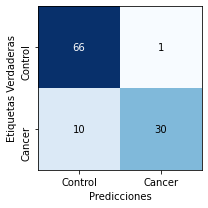

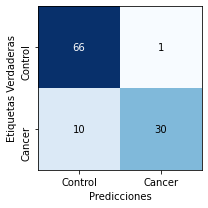

In [ ]:
#SAM with gold bboxes - Predictions
images = sam_dict2['test']['image']
true_labels = sam_dict2['test']['labels']
prediccion_final(images,true_labels)
get_failed(images,true_labels)

In [ ]:
#SAM with GOLD BBox prediction files
output_file_path='probs_ViT_SAM_goldBB.csv'
sets = ['test','valid','train']
for s in sets:
    data=[]
    images = sam_dict2[s]['image']
    true_labels = sam_dict2[s]['labels']

    get_probabilities(images,true_labels,s)

    columns = ['conjunto','name_imagen','true_class','pred_class','prob_class0','prob_class1']
    df = pd.DataFrame(data,columns=columns)

    if os.path.exists(output_file_path):
        existing_df = pd.read_csv(output_file_path)
        final_df = pd.concat([existing_df, df], ignore_index=True)
    else:
        final_df = df

    final_df.to_csv(output_file_path, index=False)

100%|███████████████████████████████████████████████████████████████████████| 107/107 [00:15<00:00,  7.08it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.815     0.985     0.892        67
           1      0.962     0.625     0.758        40

    accuracy                          0.850       107
   macro avg      0.888     0.805     0.825       107
weighted avg      0.870     0.850     0.842       107

********** MÉTRICAS **********
AUC:  0.805
True Positives:  25
True Negatives:  66
False Positives:  1
False Negatives:  15
Precisión:  0.962
Recall / Sensibilidad:  0.625
Accuracy / Exactitud:  0.85
Especificidad:  0.985
Tasa falsos negativos:  0.375
Valor predictivo positivo:  0.962
Valor predictivo negativo:  0.815
F1-Score:  0.758
******************************


100%|███████████████████████████████████████████████████████████████████████| 107/107 [00:14<00:00,  7.17it/s]


Métricas: 
00080C
00031C
00015C
00008C
00007C
00114C
00107C
00072C
00063C
00143
00068C
00120C
00049C
00027C
00109C
00115C


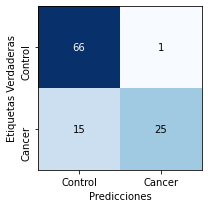

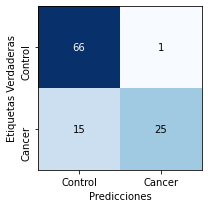

In [ ]:
#SAM with DETR Bboxes - Prediction
images = sam_dict['test']['image']
true_labels = sam_dict['test']['labels']
prediccion_final(images,true_labels)
get_failed(images,true_labels)

In [ ]:
#SAM+DETR Bbox prediction files
output_file_path='probs_ViT_SAM+DETR.csv'
sets = ['test','valid','train']
for s in sets:
    data=[]
    images = sam_dict[s]['image']
    true_labels = sam_dict[s]['labels']

    get_probabilities(images,true_labels,s)

    columns = ['conjunto','name_imagen','true_class','pred_class','prob_class0','prob_class1']
    df = pd.DataFrame(data,columns=columns)

    if os.path.exists(output_file_path):
        existing_df = pd.read_csv(output_file_path)
        final_df = pd.concat([existing_df, df], ignore_index=True)
    else:
        final_df = df

    final_df.to_csv(output_file_path, index=False)

In [ ]:
#get_attentions_maps(sam_dict2,prefijo='SAM_')
prefijo='SAM_'
sets = ['test','valid','train']
for s in sets:
    data = sam_dict2[s]
    try:
        os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s)
        os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Cáncer')
        os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Control')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

    for i in trange(len(data),desc="Procesando conjunto "+prefijo+s):
        image = data['image'][i]
        name = data['image'][i].split('/')[-1].split('.')[0]

        if 'C' in name:
            dir = './data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Cáncer/'+name
        else:
            dir = './data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Control/'+name

        input = feature_extractor([PIL.Image.open(image).convert("RGB")], return_tensors='pt')['pixel_values']
        with torch.no_grad():
            pred = model(input, output_attentions=True,interpolate_pos_encoding=True)
            save_attention(pred,input,dir)

Procesando conjunto SAM_test:   0%|          | 0/107 [00:00<?, ?it/s]

Procesando conjunto SAM_valid:   0%|          | 0/810 [00:00<?, ?it/s]

Procesando conjunto SAM_train:   0%|          | 0/1605 [00:00<?, ?it/s]

In [ ]:
#get_attentions_maps(sam_dict,prefijo='SAM+DETR_')
prefijo='SAM+DETR_'
sets = ['test','valid','train']
for s in sets:
    data = sam_dict[s]
    try:
        os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s)
        os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Cáncer')
        os.makedirs('./data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Control')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

    for i in trange(len(data),desc="Procesando conjunto "+prefijo+s):
        image = data['image'][i]
        name = data['image'][i].split('/')[-1].split('.')[0]

        if 'C' in name:
            dir = './data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Cáncer/'+name
        else:
            dir = './data_Balanced/ViT_Attention_Maps/'+prefijo+s+'/Control/'+name

        input = feature_extractor([PIL.Image.open(image).convert("RGB")], return_tensors='pt')['pixel_values']
        with torch.no_grad():
            pred = model(input, output_attentions=True,interpolate_pos_encoding=True)
            save_attention(pred,input,dir)

Procesando conjunto SAM+DETR_test:   0%|          | 0/107 [00:00<?, ?it/s]

Procesando conjunto SAM+DETR_valid:   0%|          | 0/810 [00:00<?, ?it/s]

Procesando conjunto SAM+DETR_train:   0%|          | 0/1605 [00:00<?, ?it/s]

#### About train & valid

In [ ]:
Strainer = Trainer(model=model,
                  args=Straining_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=Strain_dataset,
                  eval_dataset=Sval_dataset,
                  tokenizer=feature_extractor)

In [ ]:
#TRAIN - GOLD Seg  - Trained
Strainer.evaluate(Strain_dataset)

{'eval_loss': 0.0038987279403954744,
 'eval_f1': 1.0,
 'eval_accuracy': 1.0,
 'eval_runtime': 27.8238,
 'eval_samples_per_second': 57.684,
 'eval_steps_per_second': 28.86}

In [ ]:
#VALID - GOLD Seg  - Trained
Strainer.evaluate(Sval_dataset)

{'eval_loss': 0.005191456060856581,
 'eval_f1': 1.0,
 'eval_accuracy': 1.0,
 'eval_runtime': 16.8536,
 'eval_samples_per_second': 48.061,
 'eval_steps_per_second': 24.031}

100%|█████████████████████████████████████████████████████████████████████| 1605/1605 [03:12<00:00,  8.34it/s]


Métricas: 
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       810
           1      1.000     1.000     1.000       795

    accuracy                          1.000      1605
   macro avg      1.000     1.000     1.000      1605
weighted avg      1.000     1.000     1.000      1605



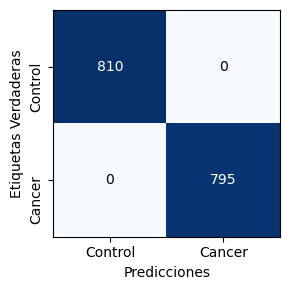

In [ ]:
#TRAIN - GOLD Seg - Predicted
images = Sdata_dict['train']['image']
true_labels = Sdata_dict['train']['labels']
predicted=[]

for ruta in tqdm(images):
    preprocessed_test_image = feature_extractor([PIL.Image.open(ruta).convert("RGB")], return_tensors='pt')['pixel_values']
    with torch.no_grad():
        preds = model(preprocessed_test_image, output_attentions=True)
        predicted.append(preds)

my_preds=[pred.logits.argmax().cpu().numpy().tolist() for pred in predicted]

print("Métricas: ")
matc=confusion_matrix(true_labels,
                      my_preds)

fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(matc, interpolation='nearest',cmap=cm.Blues)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels,rotation=90)

ax.set_xlabel('Predicciones')
ax.set_ylabel('Etiquetas Verdaderas')

thresh = matc.max() / 2.0
for i in range(matc.shape[0]):
    for j in range(matc.shape[1]):
        ax.text(j, i, format(matc[i, j], 'd'),
                ha="center", va="center",
                color="white" if matc[i, j] > thresh else "black")
plt.tight_layout()

from sklearn import metrics as pred_metrics
print(pred_metrics.classification_report(true_labels, my_preds, digits = 3))

100%|███████████████████████████████████████████████████████████████████████| 810/810 [01:42<00:00,  7.92it/s]


Métricas: 
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       405
           1      1.000     1.000     1.000       405

    accuracy                          1.000       810
   macro avg      1.000     1.000     1.000       810
weighted avg      1.000     1.000     1.000       810



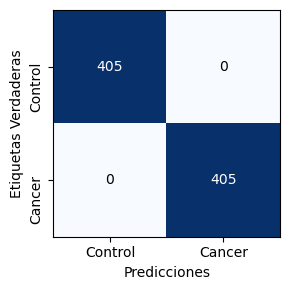

In [ ]:
#VALID - GOLD Seg - Predicted
images = Sdata_dict['valid']['image']
true_labels = Sdata_dict['valid']['labels']
predicted=[]

for ruta in tqdm(images):
    preprocessed_test_image = feature_extractor([PIL.Image.open(ruta).convert("RGB")], return_tensors='pt')['pixel_values']
    with torch.no_grad():
        preds = model(preprocessed_test_image, output_attentions=True)
        predicted.append(preds)

my_preds=[pred.logits.argmax().cpu().numpy().tolist() for pred in predicted]

print("Métricas: ")
matc=confusion_matrix(true_labels,
                      my_preds)

fig, ax = plt.subplots(figsize=(3,3))

ax.imshow(matc, interpolation='nearest',cmap=cm.Blues)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels,rotation=90)

ax.set_xlabel('Predicciones')
ax.set_ylabel('Etiquetas Verdaderas')

thresh = matc.max() / 2.0
for i in range(matc.shape[0]):
    for j in range(matc.shape[1]):
        ax.text(j, i, format(matc[i, j], 'd'),
                ha="center", va="center",
                color="white" if matc[i, j] > thresh else "black")
plt.tight_layout()

from sklearn import metrics as pred_metrics
print(pred_metrics.classification_report(true_labels, my_preds, digits = 3))

100%|█████████████████████████████████████████████████████████████████████| 1605/1605 [03:27<00:00,  7.73it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.800     0.951     0.869       810
           1      0.938     0.757     0.838       795

    accuracy                          0.855      1605
   macro avg      0.869     0.854     0.853      1605
weighted avg      0.868     0.855     0.853      1605



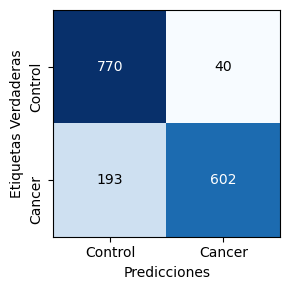

In [ ]:
#TRAIN - SAM GOLD - Predicted
images = sam_dict2['train']['image']
true_labels = sam_dict2['train']['labels']
prediccion_final(images,true_labels)

100%|███████████████████████████████████████████████████████████████████████| 810/810 [01:50<00:00,  7.35it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.762     0.958     0.849       405
           1      0.944     0.701     0.805       405

    accuracy                          0.830       810
   macro avg      0.853     0.830     0.827       810
weighted avg      0.853     0.830     0.827       810



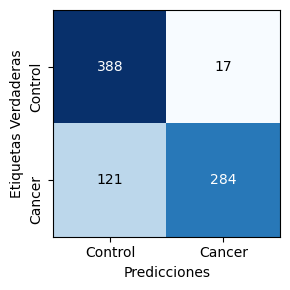

In [ ]:
#VALID - SAM GOLD - Predicted
images = sam_dict2['valid']['image']
true_labels = sam_dict2['valid']['labels']
prediccion_final(images,true_labels)

100%|█████████████████████████████████████████████████████████████████████| 1605/1605 [03:17<00:00,  8.11it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.745     0.994     0.852       810
           1      0.990     0.654     0.788       795

    accuracy                          0.826      1605
   macro avg      0.868     0.824     0.820      1605
weighted avg      0.867     0.826     0.820      1605



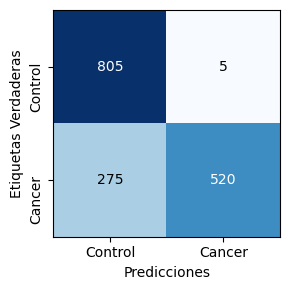

In [ ]:
#TRAIN - DETR+SAM - Predicted
images = sam_dict['train']['image']
true_labels = sam_dict['train']['labels']
prediccion_final(images,true_labels)

100%|███████████████████████████████████████████████████████████████████████| 810/810 [01:41<00:00,  7.97it/s]


Métricas: 
              precision    recall  f1-score   support

           0      0.679     0.985     0.804       405
           1      0.973     0.533     0.689       405

    accuracy                          0.759       810
   macro avg      0.826     0.759     0.746       810
weighted avg      0.826     0.759     0.746       810



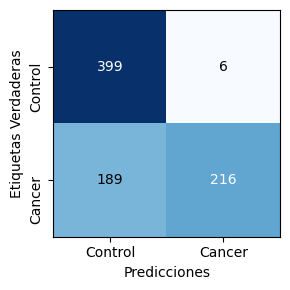

In [ ]:
#VALID - DETR+SAM - Predicted
images = sam_dict['valid']['image']
true_labels = sam_dict['valid']['labels']
prediccion_final(images,true_labels)